In [135]:
%matplotlib inline
import matplotlib as mpl
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif', size = 18)

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

from fxpmath import Fxp

import importlib
importlib.reload(funcs)  # Importing the latest version of funcs.py

<module 'funcs' from '/home/urosminoski/Desktop/FAKS/MASTER/All-Digital-RF-Transmitter-in-FPGA-master-/sim/v1.4/python/jupyter/funcs.py'>

In [152]:
# Filter coefficients
b = [3.19382974, -8.02002256, 8.73762976, -4.61756997, 0.97458298]
a = [1, -1.63632004, 1.47600867, -0.75840147, 0.2125798, -0.02541702]

N = 1024
F1 = 0.1
F2 = 0.43

n_int = 4
n_frac = 8

ds_int = 5
ds_frac = 0

# Define fixed-point format for the input/output (single precision)
fxp_type = {
    'signed': True, 
    'n_word': n_int + n_frac, 
    'n_frac': n_frac, 
    'overflow': 'saturate', 
    'rounding': 'around'
}
# Define fixed-point format for intermediate calculations (double precision)
fxp_double_type = {
    'signed': True, 
    'n_word': 2 * (n_int + n_frac), 
    'n_frac': 2 * n_frac, 
    'overflow': 'saturate', 
    'rounding': 'trunc'
}
# Define fixed-point format for output of delta-sigma modulation
fxp_ds_type = {
    'signed': True, 
    'n_word': ds_int + ds_frac, 
    'n_frac': ds_frac, 
    'overflow': 'saturate', 
    'rounding': 'trunc'
}

In [137]:
# Decompos IIR filter to parallel IIR sections
[b_parallel, a_parallel] = funcs.decompose_iir_to_parallel(b, a)

print("Section 1:")
print("\tb =", b)
print("\ta =", a, '\n\n')

print("Parallel Decomposition:")
for i in range(len(a_parallel)):
    print("Section " + str(i+1) + ":")
    print("\tb =", b_parallel[i])
    print("\ta =", a_parallel[i], "\n")

Section 1:
	b = [3.19382974, -8.02002256, 8.73762976, -4.61756997, 0.97458298]
	a = [1, -1.63632004, 1.47600867, -0.75840147, 0.2125798, -0.02541702] 


Parallel Decomposition:
Section 1:
	b = [7.376738447284568]
	a = [1, -0.3466037644977315] 

Section 2:
	b = [0.42386913756811406, -2.782525031028174]
	a = [1, -0.6659138380831608, 0.1626025786310818] 

Section 3:
	b = [-4.606777844852687, 0.023283687418655274]
	a = [1, -0.623802437419108, 0.45098689983844903] 



In [138]:
# Convert the numerator (b) and denominator (a) coefficients to fixed-point format
b_fxp = [Fxp(val, **fxp_type) for val in b]
a_fxp = [Fxp(val, **fxp_type) for val in a]
# Convert 2D arrays of numerator (b) and denominator (a) coefficients to fixed-point format
b_parallel_fxp = [[Fxp(val, **fxp_type) for val in row] for row in b_parallel]
a_parallel_fxp = [[Fxp(val, **fxp_type) for val in row] for row in a_parallel]

print("Section 1:")
print("\tb =", [val.get_val() for val in b_fxp])
print("\ta =", [val.get_val() for val in a_fxp], '\n\n')

print("Parallel Decomposition:")
for i in range(len(a_parallel_fxp)):
    print("Section " + str(i+1) + ":")
    print("\tb =", [val.get_val() for val in b_parallel_fxp[i]])
    print("\ta =", [val.get_val() for val in a_parallel_fxp[i]], "\n")

Section 1:
	b = [3.1953125, -8.0, 7.99609375, -4.6171875, 0.97265625]
	a = [1.0, -1.63671875, 1.4765625, -0.7578125, 0.2109375, -0.02734375] 


Parallel Decomposition:
Section 1:
	b = [7.375]
	a = [1.0, -0.34765625] 

Section 2:
	b = [0.42578125, -2.78125]
	a = [1.0, -0.6640625, 0.1640625] 

Section 3:
	b = [-4.60546875, 0.0234375]
	a = [1.0, -0.625, 0.44921875] 



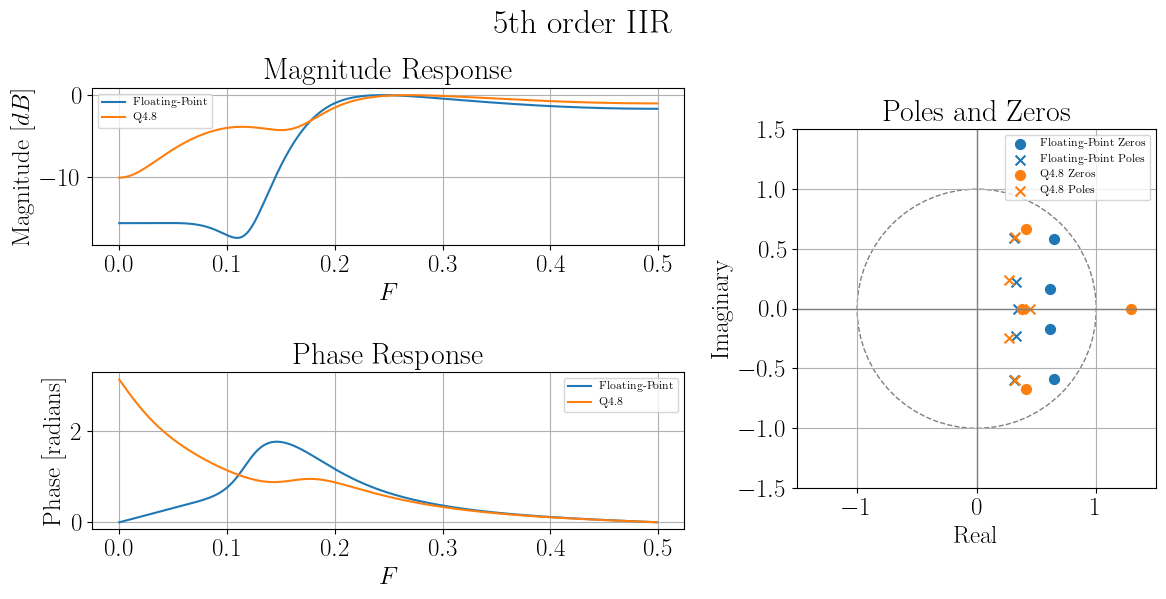

In [139]:
data_pz = [(b, a), ([val.get_val() for val in b_fxp], [val.get_val() for val in a_fxp])]
funcs.plot_IIR_and_zeros_poles(data_pz, labels=["Floating-Point", "Q4.8"], fig_title="5th order IIR")

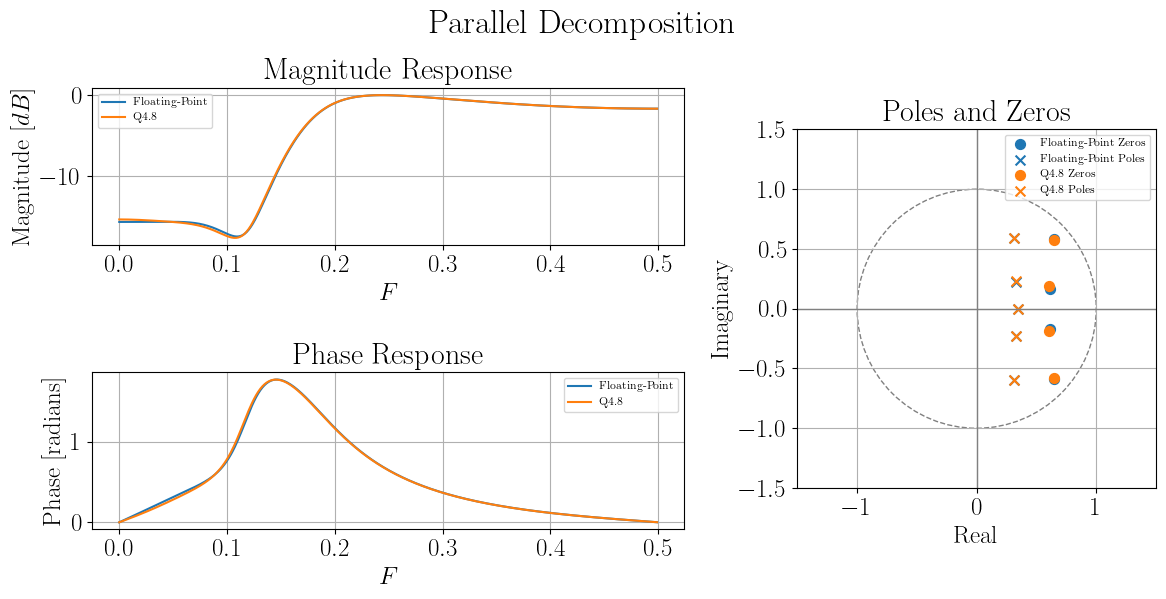

In [140]:
# Combine Parallel Sections
b_comb_fxp, a_comb_fxp = funcs.combine_parallel_sections([[val.get_val() for val in row] for row in b_parallel_fxp], [[val.get_val() for val in row] for row in a_parallel_fxp])
data_pz = [(b, a), (b_comb_fxp, a_comb_fxp)]
funcs.plot_IIR_and_zeros_poles(data_pz, labels=["Floating-Point", "Q4.8"], fig_title="Parallel Decomposition")

In [141]:
x = np.sin(2*np.pi*F1*np.arange(N)) + np.sin(2*np.pi*F2*np.arange(N))
x /= np.max(x)

y_ = signal.lfilter(b, a, x)
y = funcs.parallel_lfilter_fxp(b_parallel, a_parallel, x, n_int, n_frac)

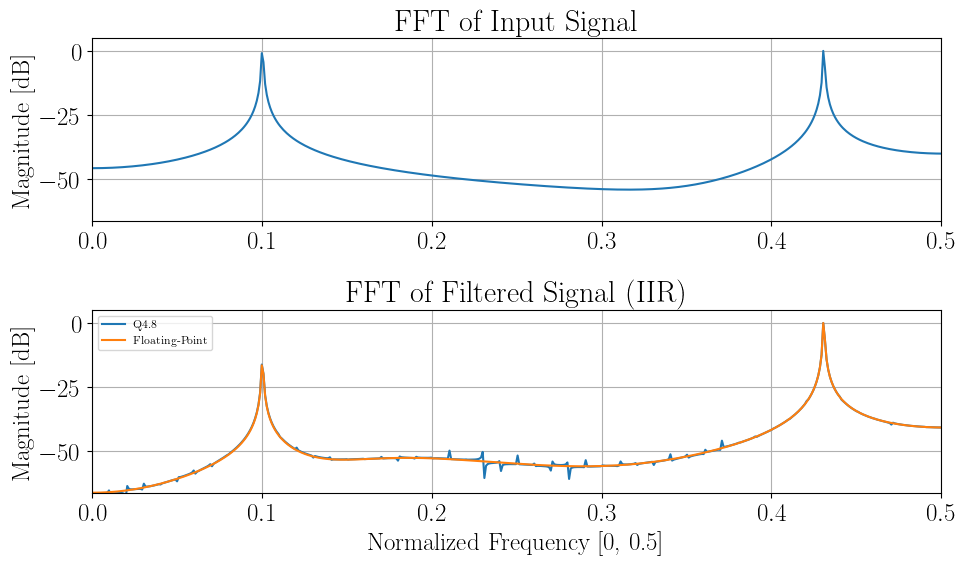

In [143]:
funcs.plot_fft_dB(x, [y, y_], title1="FFT of Input Signal", title2="FFT of Filtered Signal (IIR)", legend2=["Q4.8", "Floating-Point"])

In [150]:
M = 4
OSR = 8
x = 2**(n_int-1)*np.sin(2*np.pi*np.floor(2/7*N/OSR)*np.arange(N)/N)

In [165]:
y0 = Fxp(0, **fxp_double_type)
y0d = Fxp(0, **fxp_double_type)

y1 = Fxp(0, **fxp_double_type)
w1 = Fxp(0, **fxp_double_type)
w1d = Fxp(0, **fxp_double_type)
w1dd = Fxp(0, **fxp_double_type)

y2 = Fxp(0, **fxp_double_type)
w2 = Fxp(0, **fxp_double_type)
w2d = Fxp(0, **fxp_double_type)
w2dd = Fxp(0, **fxp_double_type)

x_fxp = Fxp(0, **fxp_type)
x_double_fxp = Fxp(0, **fxp_double_type)

yi = Fxp(0, **fxp_double_type)
yiir = Fxp(0, **fxp_double_type)
e = Fxp(0, **fxp_double_type)
v = Fxp(0, **fxp_ds_type)
v_tmp = Fxp(0, **fxp_double_type)

b_double = [[Fxp(val, **fxp_double_type) for val in row] for row in b_parallel_fxp]

for n in range(len(x)):
    x_fxp(x[n])
    tmp1 = x_fxp+yiir
    yi(tmp1.get_val())
    v(yi.get_val())

    v_tmp(v.get_val())
    tmp2 = yi-v_tmp
    e(tmp2.get_val())

    y0 = b_parallel_fxp[0]

In [ ]:
b_parallel_fxp

In [162]:
a = Fxp(2.12345112, **fxp_type)
b = Fxp(0, **fxp_ds_type)
print(a.info(verbose=3))
b(a.get_val())
print(b.info(verbose=3))

	dtype		=	fxp-s12/8
	Value		=	2.125
	inaccuracy	=	True

	Signed		=	True
	Word bits	=	12
	Fract bits	=	8
	Int bits	=	3
	Val data type	=	<class 'float'>

	Upper		=	7.99609375
	Lower		=	-8.0
	Precision	=	0.00390625
	Overflow	=	saturate
	Rounding	=	around
	Shifting	=	expand

None
	dtype		=	fxp-s5/0
	Value		=	2.0
	inaccuracy	=	True

	Signed		=	True
	Word bits	=	5
	Fract bits	=	0
	Int bits	=	4
	Val data type	=	<class 'numpy.float64'>

	Upper		=	15.0
	Lower		=	-16.0
	Precision	=	1.0
	Overflow	=	saturate
	Rounding	=	trunc
	Shifting	=	expand

None
